In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
import utils
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')
from PIL import Image

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
22495  MURA-v1.1\train\XR_SHOULDER\patient01234\study...  train  XR_SHOULDER   
29133  MURA-v1.1\train\XR_WRIST\patient06454\study1_p...  train     XR_WRIST   
3082   MURA-v1.1\train\XR_ELBOW\patient05681\study1_n...  train     XR_ELBOW   
12805  MURA-v1.1\train\XR_HAND\patient06055\study2_ne...  train      XR_HAND   
16054  MURA-v1.1\train\XR_HAND\patient10695\study1_ne...  train      XR_HAND   
13173  MURA-v1.1\train\XR_HAND\patient08710\study1_po...  train      XR_HAND   
34042  MURA-v1.1\train\XR_WRIST\patient08169\study1_n...  train     XR_WRIST   
25788  MURA-v1.1\train\XR_SHOULDER\patient02290\study...  train  XR_SHOULDER   
22436  MURA-v1.1\train\XR_SHOULDER\patient01213\study...  train  XR_SHOULDER   
29111  MURA-v1.1\train\XR_WRIST\patient06446\study1_p...  train     XR_WRIST   

            Patient       FolderName   Study     Label  
22495  patient01234  study1_positive  study1  positive  
29133  patient06454  study1_positive  study1  positive  
3082   patient05681  study1_negative  study1  negative  
12805  patient06055  study2_negative  study2  negative  
16054  patient10695  study1_negative  study1  negative  
13173  patient08710  study1_positive  study1  positive  
34042  patient08169  study1_negative  study1  negative  
25788  patient02290  study1_negative  study1  negative  
22436  patient01213  study1_positive  study1  positive  
29111  patient06446  study1_positive  study1  positive

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


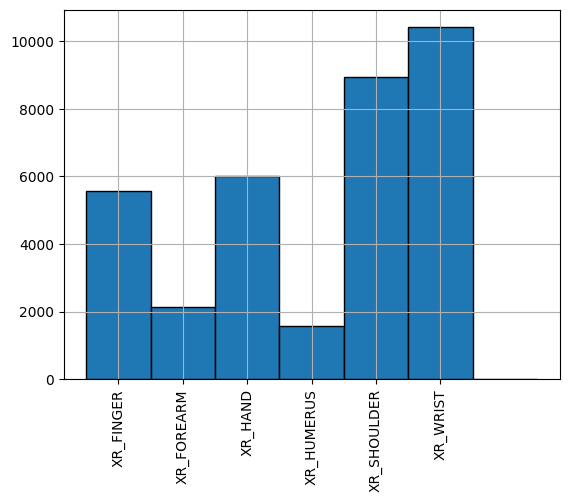

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient06312\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04687\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09346\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient11149\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient03146\study1...  train   XR_HUMERUS   
5   MURA-v1.1\valid\XR_SHOULDER\patient11550\study...  valid  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient08593\study1_n...  train     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient05087\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\train\XR_FINGER\patient03801\study1_...  train    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient00297\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient09794\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02890\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient01022\study...  train  XR_SHOULDER   
13  MURA-v1.1\train\XR_WRIST\patient07393\study1_p...  train     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient06312  study1_negative  study1  negative  
1   patient04687  study1_negative  study1  negative  
2   patient09346  study1_negative  study1  negative  
3   patient11149  study1_negative  study1  negative  
4   patient03146  study1_negative  study1  negative  
5   patient11550  study1_negative  study1  negative  
6   patient08593  study1_negative  study1  negative  
7   patient05087  study1_positive  study1  positive  
8   patient03801  study1_positive  study1  positive  
9   patient00297  study1_positive  study1  positive  
10  patient09794  study1_positive  study1  positive  
11  patient02890  study1_positive  study1  positive  
12  patient01022  study1_positive  study1  positive  
13  patient07393  study1_positive  study1  positive

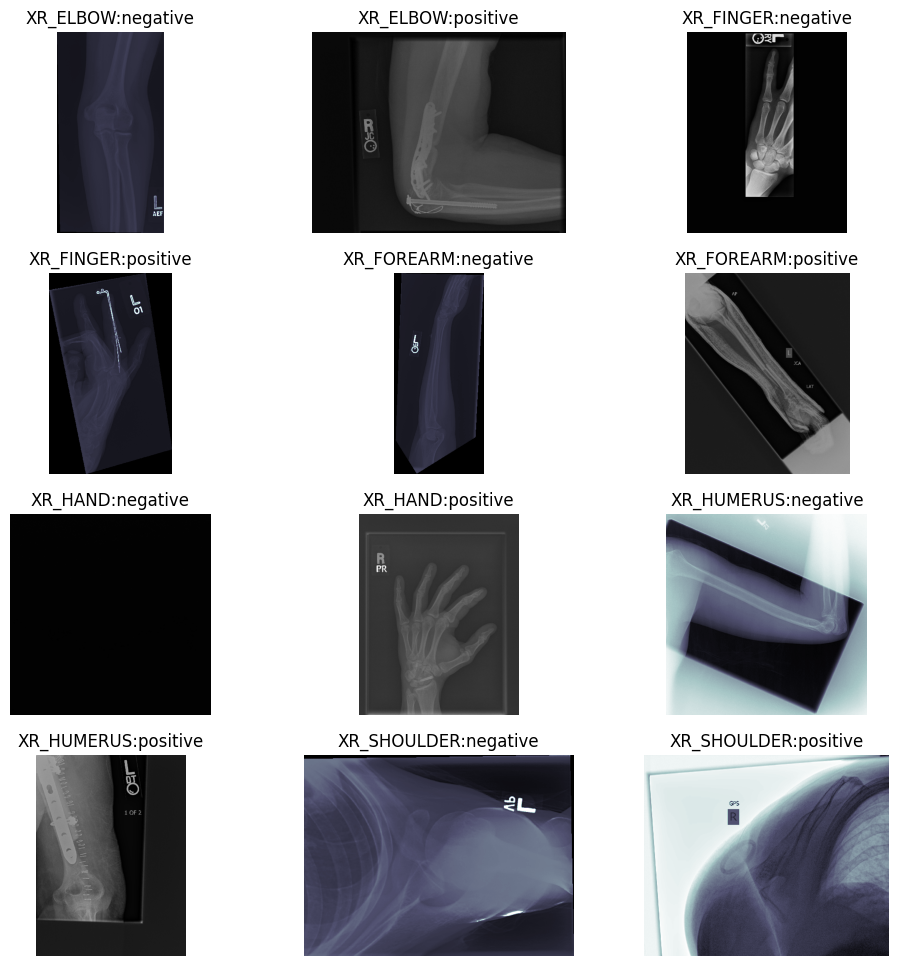

In [7]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
17564  MURA-v1.1\train\XR_HUMERUS\patient02713\study1...  train  XR_HUMERUS   
17904  MURA-v1.1\train\XR_HUMERUS\patient02862\study1...  train  XR_HUMERUS   
38552  MURA-v1.1\valid\XR_HUMERUS\patient11396\study1...  valid  XR_HUMERUS   
17650  MURA-v1.1\train\XR_HUMERUS\patient02750\study1...  train  XR_HUMERUS   
18158  MURA-v1.1\train\XR_HUMERUS\patient02978\study1...  train  XR_HUMERUS   
18285  MURA-v1.1\train\XR_HUMERUS\patient03038\study1...  train  XR_HUMERUS   
18124  MURA-v1.1\train\XR_HUMERUS\patient02961\study1...  train  XR_HUMERUS   
18441  MURA-v1.1\train\XR_HUMERUS\patient03112\study1...  train  XR_HUMERUS   
38609  MURA-v1.1\valid\XR_HUMERUS\patient11625\study1...  valid  XR_HUMERUS   
18423  MURA-v1.1\train\XR_HUMERUS\patient03104\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
17564  patient02713  study1_positive  study1  positive  
17904  patient02862  study1_positive  study1  positive  
38552  patient11396  study1_negative  study1  negative  
17650  patient02750  study1_positive  study1  positive  
18158  patient02978  study1_negative  study1  negative  
18285  patient03038  study1_negative  study1  negative  
18124  patient02961  study1_negative  study1  negative  
18441  patient03112  study1_negative  study1  negative  
38609  patient11625  study1_positive  study1  positive  
18423  patient03104  study1_negative  study1  negative

In [50]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.color import gray2rgb
from torchvision import transforms
class NoneTransform:
    def __call__(self, im):
        return im
class HumerusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = self.df['Label'].map({'positive': 1, 'negative': 0})
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path=self.df['path'].iloc[idx]
        # this does not works???
        img = Image.open(path)
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x:x.repeat(3,1,1)) if img.mode!='RGB' else NoneTransform(),
            ])    
        img = self.transform(img)
        return img, self.labels.iloc[idx]

torch.Size([3, 512, 420])


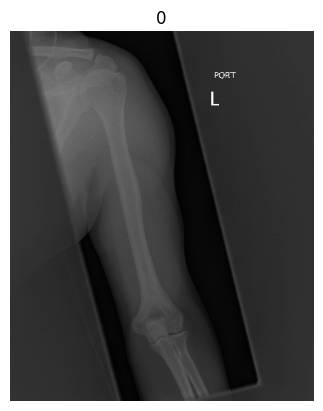

In [56]:
img, label = HumerusDataset(humerus_df).__getitem__(5)
print(img.shape)
utils.show_image_w_label(img[0], label)

In [57]:
BATCH_SIZE=32
train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy()), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy()), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002B4EFA9ED10>, <torch.utils.data.dataloader.DataLoader object at 0x000002B4EDA18370>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


In [58]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

RuntimeError: stack expects each tensor to be equal size, but got [3, 512, 420] at entry 0 and [1, 512, 440] at entry 5